### Exploratory Data Analysis of Amazon Book Review

#### This dataset is taken from http://jmcauley.ucsd.edu/data/amazon/

<li> Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015


<li> Inferring networks of substitutable and complementary products
J. McAuley, R. Pandey, J. Leskovec
Knowledge Discovery and Data Mining, 2015

This is the book review 5-core data which means that each user and item has 5 reviews each. This is an analysis for a small subset (20,000 rows).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
        if i > 20000:
            break
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Books_5.json.gz')

In [3]:
df.head(1)

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",1355616000,Spiritually and mentally inspiring! A book tha...,5.0,"12 16, 2012",Wonderful!


Let's look at the distributions of ratings given by each reviewers-

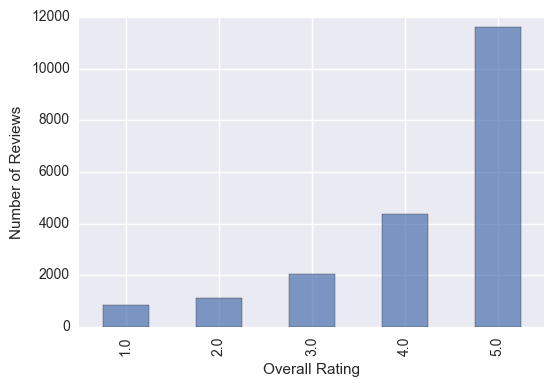

In [4]:
df.groupby('overall').size().plot(kind = 'bar', alpha = 0.7)
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')

80% of the ratings are 4 and 5 stars. 

### Books with most reviews

<p> Minimum, maximum and average number of reviews :

In [5]:
df.groupby('asin').size().min(), df.groupby('asin').size().max(), df.groupby('asin').size().mean()

(5, 2721, 54.35054347826087)

#### 25 Books with most number of reviews

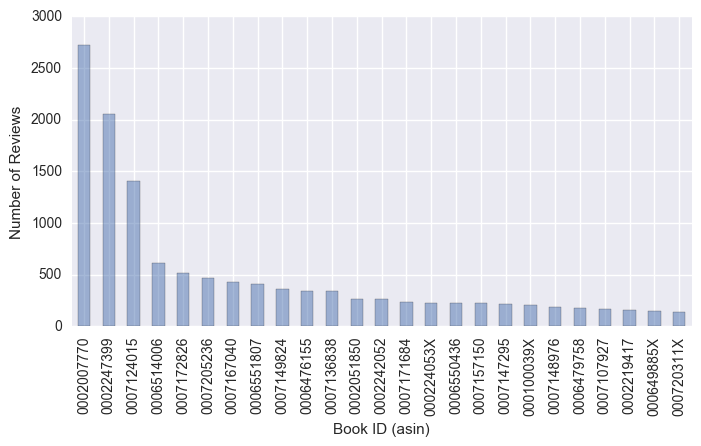

In [6]:
plt.figure(figsize=[8, 4])
df.groupby('asin').size().sort_values(ascending=False)[:25].plot(kind = 'bar', alpha = 0.5) 
plt.xlabel('Book ID (asin)')
plt.ylabel('Number of Reviews')

*I am going to look at the first one (a bit sidetracked but want to see which book received the most reviews).*

C:\Users\Bis\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


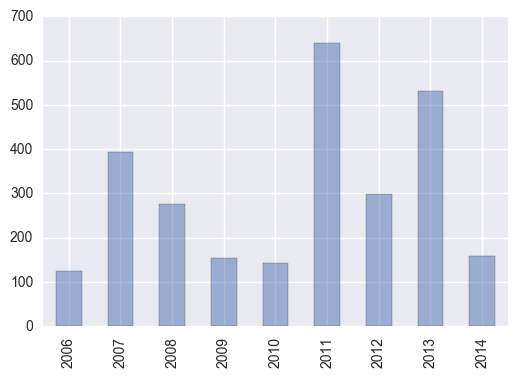

In [7]:
book_770 = df[df.asin == '0002007770']
book_770.loc[:, 'reviewTime'] =  pd.to_datetime(book_770.loc[:, 'reviewTime'])
book_770.reviewTime.dt.year.value_counts().sort_index().plot(kind = 'bar', alpha = 0.5)

It turns out that *Water for Elephant* (ISBN = 0002007770, https://en.wikipedia.org/wiki/Water_for_Elephants)  was published in 2006 and a movie based on this book came out in 2011 (hence the spike in 2011). 

### Reviewers with most reviews

In [8]:
len(df.reviewerID.unique()) # There are 16,971 distinct reviewers among 20,000 total

16971

Minimum, maximum and average number of reviews per reviewer: (Min number here should be 5 but this a subset of the whole dataset.

In [9]:
df.groupby('reviewerID').size().min(), df.groupby('reviewerID').size().max(), df.groupby('reviewerID').size().mean()

(1, 22, 1.1785398621177303)

#### First 25 reviewers

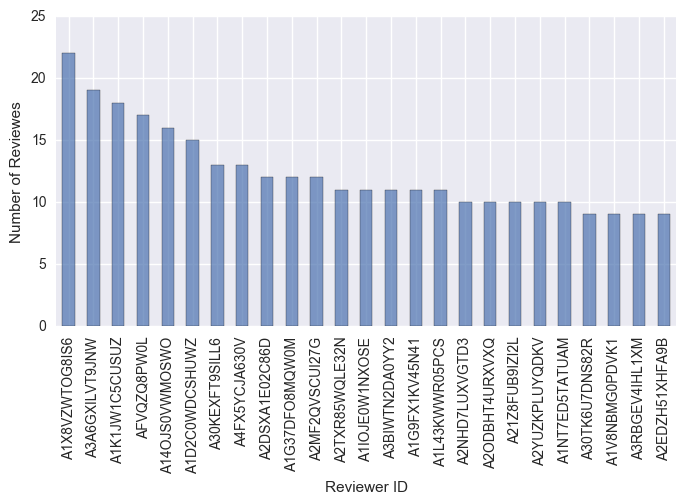

In [10]:
plt.figure(figsize=[8, 4])
df.groupby('reviewerID').size().sort_values(ascending=False)[:25].plot(kind = 'bar', alpha = 0.7) 
plt.xlabel('Reviewer ID')
plt.ylabel('Number of Reviewes')

### Trend of reviews over the years

In [11]:
df.loc[:, 'reviewTime'] =  pd.to_datetime(df.loc[:, 'reviewTime'])

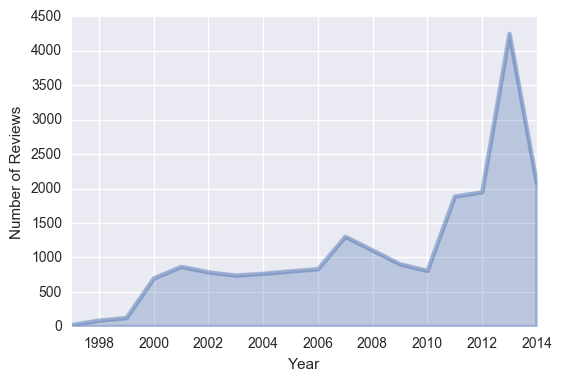

In [12]:
df.groupby(df.reviewTime.dt.year).size().plot(kind = 'area', alpha = 0.3, linewidth = 3.0) 
plt.xlabel('Year')
plt.ylabel('Number of Reviews')

The number of reviews increased from less than 100 (in 1997) to ~4500 (in 2013). 2007-2009 shows a dip - this was during economic slowdown in the US. Similar analysis can be done with the months:

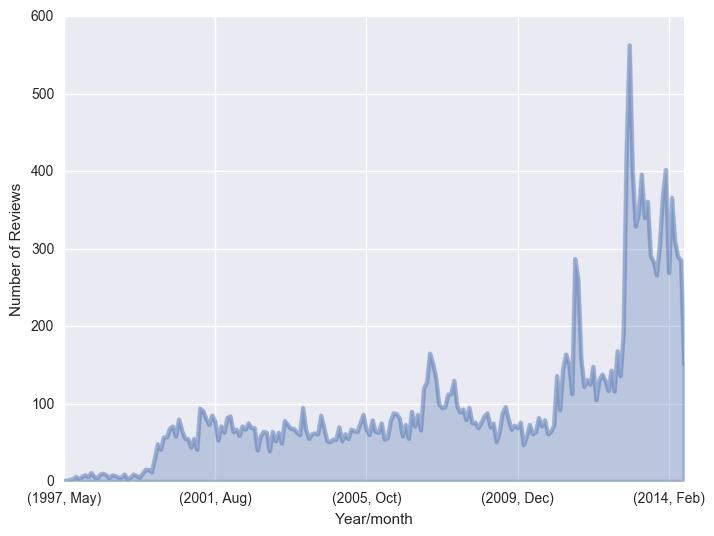

In [13]:
plt.figure(figsize=[8, 6])
g = df.groupby([df.reviewTime.dt.year, df.reviewTime.dt.month]).size()
g.index.set_levels([[1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
                    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']],inplace=True)
g.plot(kind = 'area', alpha = 0.3, linewidth = 3.0) 
plt.xlabel('Year/month')
plt.ylabel('Number of Reviews')

### Review texts 

-Let's calculate the length of the texts

In [14]:
from textblob import TextBlob, Word, Blobber
import nltk

In [15]:
df['len_words'] = df['reviewText'].apply(lambda x: len(TextBlob(x).words))

In [16]:
df.head(1)

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary,len_words
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",1355616000,Spiritually and mentally inspiring! A book tha...,5.0,2012-12-16,Wonderful!,22


In [17]:
df.len_words.describe() # See min, max, mean, std dev 

count    20001.000000
mean       157.045248
std        183.730816
min          0.000000
25%         42.000000
50%         95.000000
75%        202.000000
max       3505.000000
Name: len_words, dtype: float64

In [18]:
dr = df[['len_words', 'reviewerID']]

In [19]:
bins1 = [-.09, 100, 200, 500, 750, 1000, 2000, 4000]
bins1

[-0.09, 100, 200, 500, 750, 1000, 2000, 4000]

In [20]:
group_names1 = ['0-100', '101-200', '201-500', '501-750', '751-1000', '1000-2000', '2000-4000']

In [21]:
dr['category'] = pd.cut(dr['len_words'], bins1, labels=group_names1)
dr.head(1)

C:\Users\Bis\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,len_words,reviewerID,category
0,22,A10000012B7CGYKOMPQ4L,0-100


In [22]:
pd.value_counts(dr['category'])

0-100        10411
101-200       4535
201-500       4022
501-750        711
751-1000       206
1000-2000      108
2000-4000        8
Name: category, dtype: int64

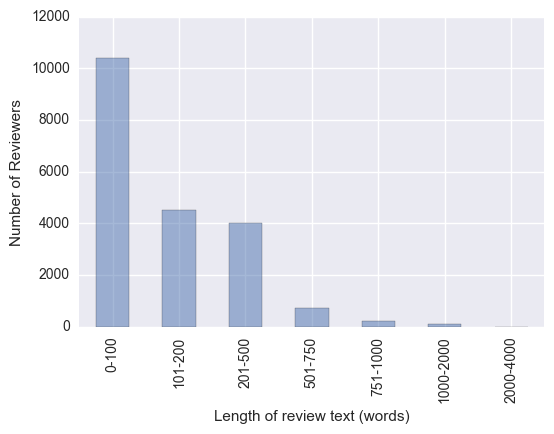

In [23]:
pd.value_counts(dr['category']).plot(kind='bar', alpha = 0.5)
plt.xlabel('Length of review text (words)')
plt.ylabel('Number of Reviewers')

More than 50% of the reviewers have written reviews under 100 words. More than 75% of the total reviewers has written reviews under 500 words. 2000-4000 words ranges are written by a few ones (only 8). 

### Helpfulness rating

The length of the text or the overall star ratings are not very useful without the helpfulness rating system.

The first element in the helpful column is the number of 'yes' vote and the second element represents the total vote. We are going to create a percentage rating column based on (yes/total). [Note that 90/100 will have the same percentage rating as 9/10 but I am not taking the weighted average]

In [24]:
df[['helpfulVote', 'totalVote']] = df['helpful'].apply(pd.Series)
df1 = df.drop('helpful', axis = 1)
df1.head(1)

,reviewerID,asin,reviewerName,unixReviewTime,reviewText,overall,reviewTime,summary,len_words,helpfulVote,totalVote
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,1355616000,Spiritually and mentally inspiring! A book tha...,5.0,2012-12-16,Wonderful!,22,0,0


In [25]:
df1.shape

(20001, 11)

In [26]:
df1['percHelpful'] = df1.helpfulVote/df.totalVote
df1['percHelpful'] = df1['percHelpful'].fillna(0)
df1.head(1)

,reviewerID,asin,reviewerName,unixReviewTime,reviewText,overall,reviewTime,summary,len_words,helpfulVote,totalVote,percHelpful
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,1355616000,Spiritually and mentally inspiring! A book tha...,5.0,2012-12-16,Wonderful!,22,0,0,0.0


In [27]:
df1 = df1[df1.percHelpful <= 1.00] # one element was more than 1.0, must be some wrong total vote.

In [28]:
df.shape

(20001, 12)

In [29]:
df1.shape

(20000, 12)

In [30]:
df1.percHelpful.describe()

count    20000.000000
mean         0.426529
std          0.431731
min          0.000000
25%          0.000000
50%          0.333333
75%          0.937500
max          1.000000
Name: percHelpful, dtype: float64

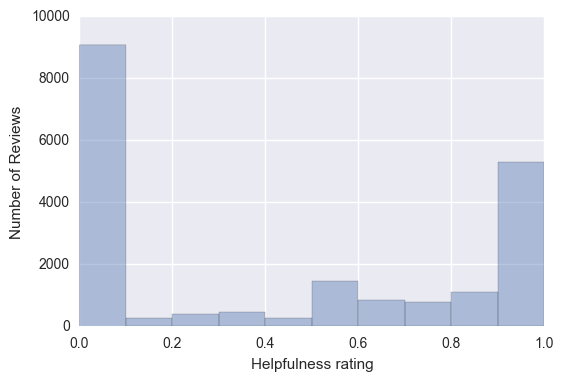

In [31]:
sns.distplot(df1.percHelpful, kde = False, bins = 10)
plt.xlabel('Helpfulness rating')
plt.ylabel('Number of Reviews')

<li> Most of the helpfulness ratings are either 0 or 1. 

### Reviewers with most reviews and their helpfulness ratings 

In [32]:
df1.groupby('reviewerID').size().sort_values(ascending=False)[:15] # First 15 reviewers with most number of reviews

reviewerID
A1X8VZWTOG8IS6    22
A3A6GXILVT9JNW    19
A1K1JW1C5CUSUZ    18
AFVQZQ8PW0L       17
A14OJS0VWMOSWO    16
A1D2C0WDCSHUWZ    15
A30KEXFT9SILL6    13
A4FX5YCJA630V     13
A2DSXA1E02C86D    12
A1G37DFO8MQW0M    12
A2MF2QVSCUI27G    12
A1G9FX1KV45N41    11
A2TXR85WQLE32N    11
A1IOJE0W1NXOSE    11
A3BIWTN2DA0YY2    11
dtype: int64

#### Reviewer #1 and overall ratings (given by the reviewer)

In [33]:
drev1 = df1[df1.reviewerID == 'A1X8VZWTOG8IS6'] #reviewer number 1

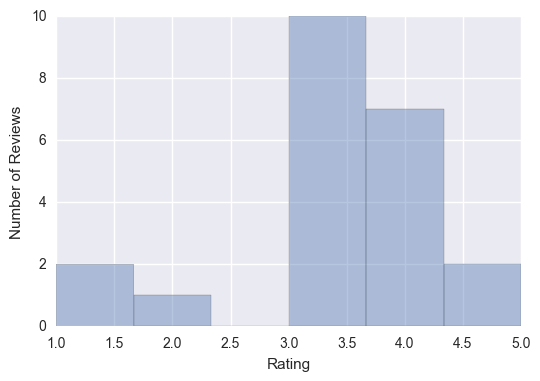

In [34]:
sns.distplot(drev1.overall, kde = False)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

<li> Most frequent ratings by this reviewer are 3 and 4.

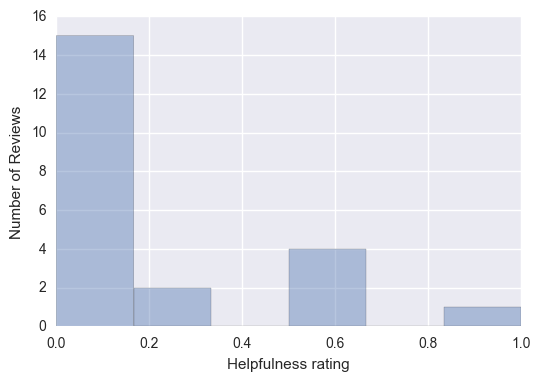

In [35]:
sns.distplot(drev1.percHelpful, kde = False)
plt.xlabel('Helpfulness rating')
plt.ylabel('Number of Reviews')

Most of the timeThe reviews are **NOT** helpful. We will do a hypothesis testing based on this behavior.

### Reviewers with more than 30% helpfulness rating 

In [36]:
df2 = df1[df1.percHelpful >= 0.30]

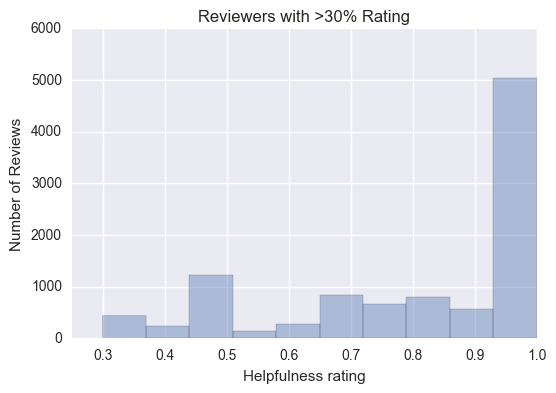

In [37]:
sns.distplot(df2.percHelpful, kde = False, bins = 10)
plt.xlabel('Helpfulness rating')
plt.ylabel('Number of Reviews')
plt.xlim([0.25, 1.0])
plt.title('Reviewers with >30% Rating')

#### 25 reviewers with more than 30% helpfulness rating

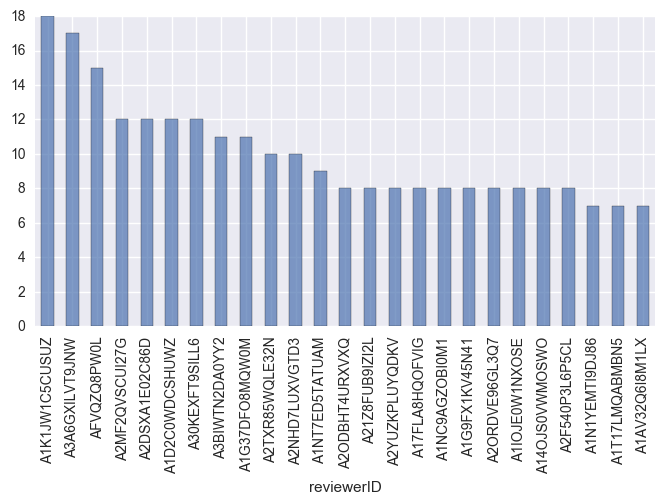

In [38]:
plt.figure(figsize=[8, 4])
df2.groupby('reviewerID').size().sort_values(ascending=False)[:25].plot(kind = 'bar', alpha = 0.7)

### How review text length relates to helpfulness rating

In [39]:
df1['len_words'].corr(df1['percHelpful']) # all ratings

0.25864047751593844

In [40]:
df2['len_words'].corr(df2['percHelpful']) # >30% useful rating

0.0079700576755098815

(-100, 3600)

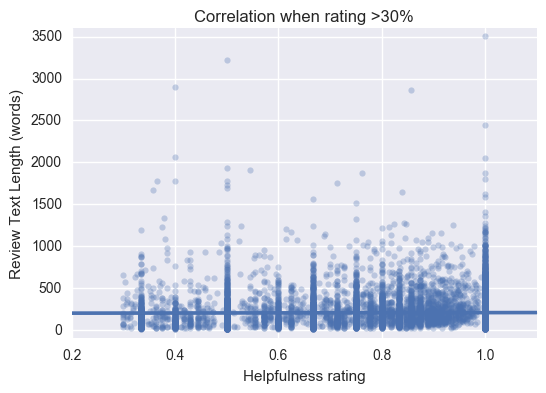

In [41]:
sns.regplot(x = 'percHelpful', y = 'len_words', data = df2, scatter_kws={'alpha':0.3}, fit_reg= True)
plt.xlabel('Helpfulness rating')
plt.ylabel('Review Text Length (words)')
plt.title('Correlation when rating >30%')
plt.ylim([-100, 3600])

(-100, 3600)

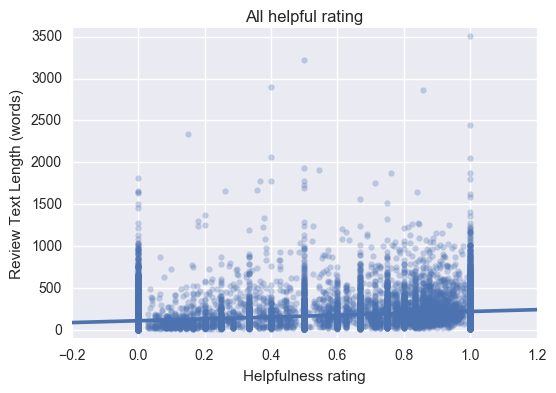

In [42]:
sns.regplot(x = 'percHelpful', y = 'len_words', data = df1, scatter_kws={'alpha':0.3}, fit_reg= True)
plt.xlabel('Helpfulness rating')
plt.ylabel('Review Text Length (words)')
plt.title('All helpful rating')
plt.ylim([-100, 3600])

When the helpfulness rating is greater than 30%, the correlation between review text length and rating is low (0.007). On the other hand, the correlation is slightly better (0.25) but not strong considering all ratings. In both cases though, most helpful (>30%) and unhelpful (<30%) reviews are written between 0-500 words.

### The range of helpfulness rating

In [43]:
bins = [-.09, .25, 0.5, .75, 1.01 ]
bins

[-0.09, 0.25, 0.5, 0.75, 1.01]

In [44]:
group_names = ['below 25%', '25-50%', '51-75%', '76-100%']

In [45]:
df1['category'] = pd.cut(df1['percHelpful'], bins, labels=group_names)
df1.head(1)

,reviewerID,asin,reviewerName,unixReviewTime,reviewText,overall,reviewTime,summary,len_words,helpfulVote,totalVote,percHelpful,category
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,1355616000,Spiritually and mentally inspiring! A book tha...,5.0,2012-12-16,Wonderful!,22,0,0,0.0,below 25%


In [46]:
pd.value_counts(df1['category'])

below 25%    9657
76-100%      6587
25-50%       1984
51-75%       1772
Name: category, dtype: int64

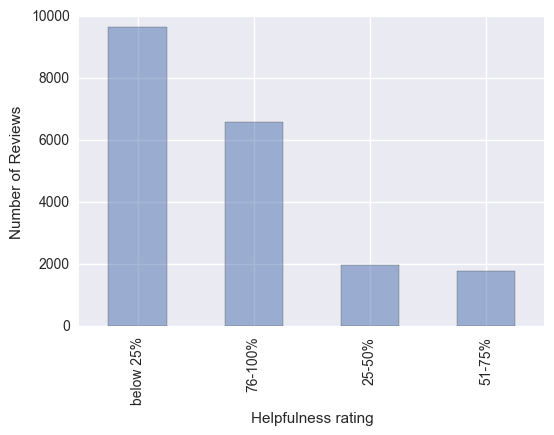

In [47]:
pd.value_counts(df1['category']).plot(kind='bar', alpha = 0.5)
plt.xlabel('Helpfulness rating')
plt.ylabel('Number of Reviews')

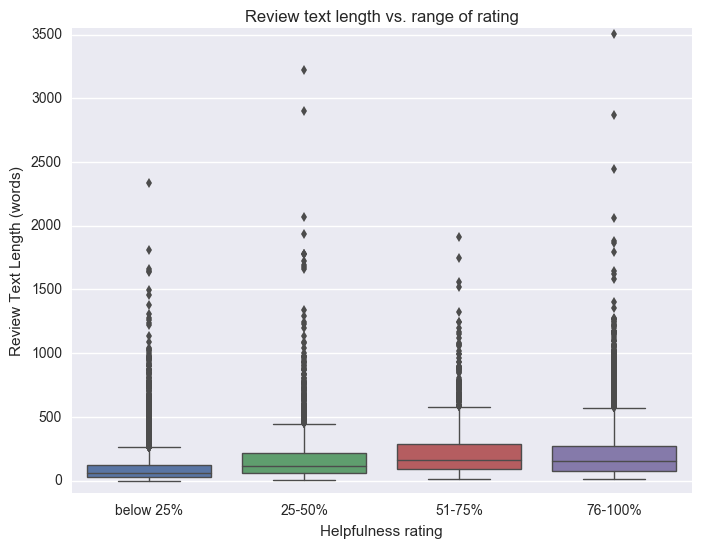

In [48]:
plt.figure(figsize=(8, 6)) 
sns.set_style("darkgrid")
sns.boxplot(y="len_words", x="category", data=df1, palette="deep", linewidth= 1)
sns.despine(left=True)
plt.ylim([-100, 3550])
plt.xlabel('Helpfulness rating')
plt.ylabel('Review Text Length (words)')
plt.title('Review text length vs. range of rating')

### Review text length and overall rating 

In [49]:
df3 = df1[['overall', 'len_words']]

In [50]:
df3.describe()

,overall,len_words
count,20000.000000,20000.00000
mean,4.236500,157.04290
std,1.112128,183.73511
min,1.000000,0.00000
25%,4.000000,42.00000
50%,5.000000,94.50000
75%,5.000000,202.00000
max,5.000000,3505.00000


In [51]:
g = df3.groupby('overall')
g.describe()

len_words
overall                    
1.0     count    851.000000
        mean     179.075206
        std      193.058605
        min        1.000000
        25%       61.000000
        50%      118.000000
        75%      222.500000
        max     1868.000000
2.0     count   1135.000000
        mean     189.171806
        std      195.471206
        min        3.000000
        25%       64.000000
        50%      125.000000
        75%      236.000000
        max     1775.000000
3.0     count   2051.000000
        mean     188.432960
        std      194.795933
        min        1.000000
        25%       57.000000
        50%      127.000000
        75%      247.000000
        max     2058.000000
4.0     count   4359.000000
        mean     175.833448
        std      187.091561
        min        6.000000
        25%       49.000000
        50%      115.000000
        75%      237.000000
        max     2338.000000
5.0     count  11604.000000
        mean     139.677784
        std      176.424876
        min        0.000000
        25%       37.000000
        50%       78.000000
        75%      175.000000
        max     3505.000000

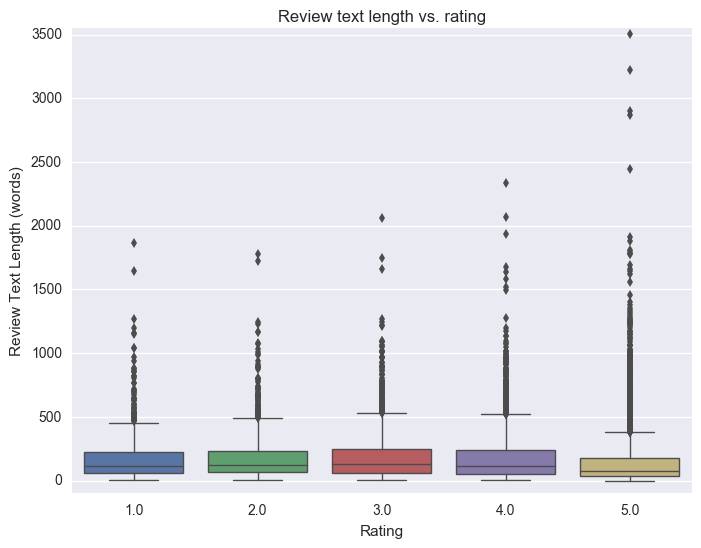

In [52]:
plt.figure(figsize=(8, 6)) 
sns.set_style("darkgrid")
sns.boxplot(y="len_words", x="overall", data=df3, palette="deep", linewidth= 1)
sns.despine(left=True)
plt.ylim([-100, 3550])
plt.xlabel('Rating')
plt.ylabel('Review Text Length (words)')
plt.title('Review text length vs. rating')

<li> 75% of all ratings are about 500 words (1 paragraph).
<li> Reviewers have written more words for 4 & 5 star ratings. 

###  Evolution of review text length (over time) 

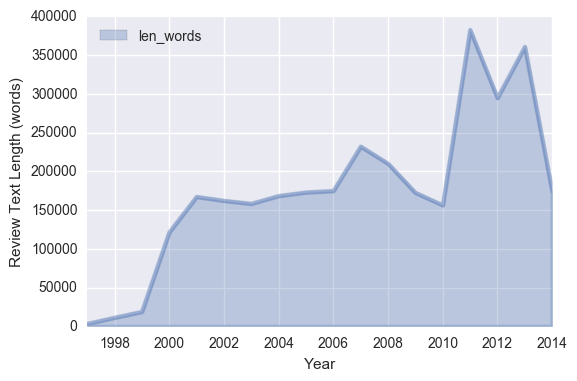

In [53]:
dh = df[['reviewTime', 'len_words']]
dh = dh.groupby(dh.reviewTime.dt.year).sum()
dh.plot(kind = 'area', alpha = 0.3, linewidth = 3.0)
plt.xlabel('Year')
plt.ylabel('Review Text Length (words)')

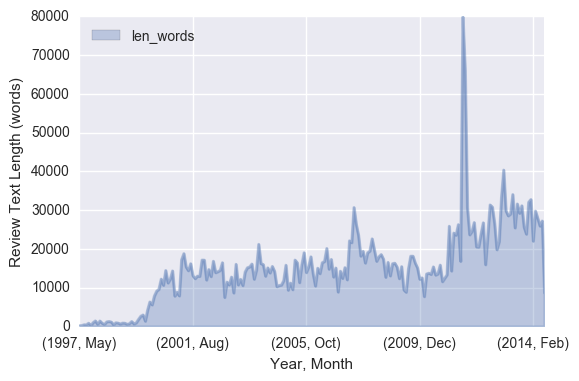

In [54]:
plt.figure(figsize=[8, 6])
dh = df[['reviewTime', 'len_words']]
dh = dh.groupby([dh.reviewTime.dt.year, dh.reviewTime.dt.month]).sum()
dh.index.set_levels([[1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
                    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']],inplace=True)
dh.plot(kind = 'area', alpha = 0.3, linewidth = 2)
plt.xlabel('Year, Month')
plt.ylabel('Review Text Length (words)')

### What are the most frequent words in positive and negative reviews

In [55]:
dw = df [['summary', 'overall']]
dw.head()

,summary,overall
0,Wonderful!,5.0
1,close to god,5.0
2,Must Read for Life Afficianados,5.0
3,Timeless for every good and bad time in your l...,5.0
4,A Modern Rumi,5.0


In [56]:
def partition(x):
    if x < 3.0:
        return 'negative'
    return 'positive'

rating = dw['overall']
rating = rating.map(partition)

tmp = dw
tmp['overall'] = tmp['overall'].map(partition)

C:\Users\Bis\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
dw[dw.overall == 'positive'][:2]

,summary,overall
0,Wonderful!,positive
1,close to god,positive


In [58]:
dw[dw.overall == 'negative'][:2]

,summary,overall
23,Eloquent,negative
70,"Unfortunately, the twin credos of ""The Prophet...",negative


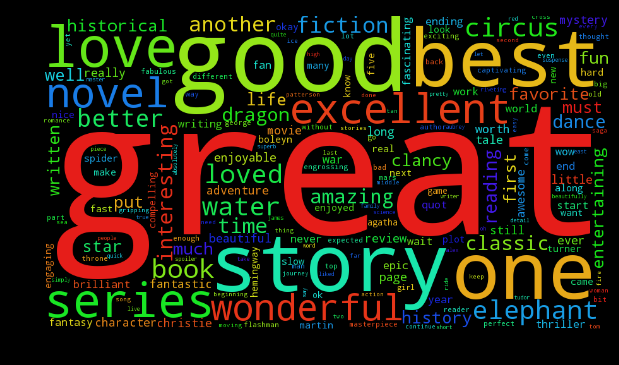

In [59]:
# This one is taken from kaggle kernel of amazon fine food review

from wordcloud import WordCloud
import string
from string import maketrans

positive_words = ''
negative_words = ''

intab = string.punctuation
outtab = "                                "
trantab = maketrans(intab, outtab)

pos = dw.loc[dw['overall'] == 'positive']
pos = pos[0:10000]

neg = dw.loc[dw['overall'] == 'negative']
neg = neg[0:10000]

from nltk.corpus import stopwords

for val in pos["summary"]:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    if "book" in tokens:
        tokens.remove("book")
    if "read" in tokens:
        tokens.remove("read")
    
    for words in tokens:
        positive_words = positive_words + words + ' '
        
for val in neg["summary"]:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    if "good" in tokens:
        tokens.remove("good")
    if "book" in tokens:
        tokens.remove("book")
    if "read" in tokens:
        tokens.remove("read")
    
    for words in tokens:
        negative_words = negative_words + words + ' '

# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(positive_words)
neg_wordcloud = WordCloud(width=900, height=500).generate(negative_words)

plt.figure( figsize=(6, 4), facecolor='k')
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()
plt.savefig('positivewordclouds.jpeg', facecolor='k', bbox_inches='tight')


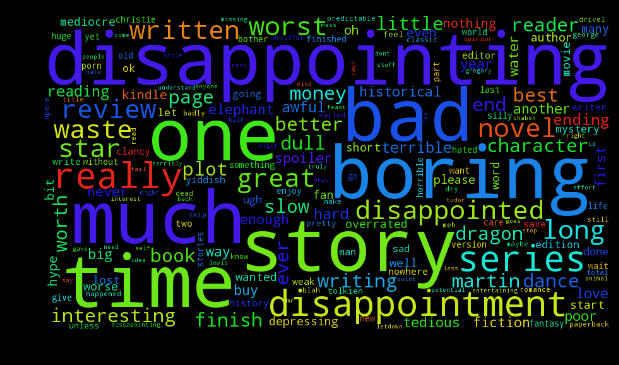

In [60]:
plt.figure( figsize=(6, 4), facecolor='k')
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
plt.savefig('negativewordclouds.jpeg', facecolor='k', bbox_inches='tight')